In [1]:
import os

import numpy   as np
import pandas  as pd
import seaborn as sns

from matplotlib.pyplot import subplots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.svm             import SVC
from sklearn.metrics         import classification_report

from aequitas.preprocessing import preprocess_input_df
from aequitas.group         import Group
from aequitas.bias          import Bias
from aequitas.fairness      import Fairness
from aequitas.plotting      import Plot


%matplotlib inline

In [2]:
# global variables

DATASET_PATH = os.path.join(os.getcwd(), "hearth_disease.csv")

# 1. What is the dataset ?

The dataset pertains to the diagnosis of heart disease and consists of numeric-valued attributes. It contains 693 (one duplicate row) instances, with only 12 attributes being used for analysis, which are described as below:

   
   01. `age`: displays the age of the individual in years.
   
   
   02. `sex`: displays the gender of the individual using the following format:
      * 0 = Female
      * 1 = Male
   
   
   03. `cp`: displays the type of chest-pain experienced by the individual using the following format:
      * 1 = Typical angina
      * 2 = Atypical angina
      * 3 = Non-anginal pain
      * 4 = Asymptotic
   
   
   04. `trestbps`: displays the resting blood pressure value of an individual in mmHg (unit).
   
   
   05. `chol`: displays the serum cholesterol in mg/dl (unit).
   
   
   06. `fbs`: compares the fasting blood sugar value of an individual with 120 mg/dl. If fasting blood sugar > 120 mg/dl then it is 1 (true), otherwise it is 0 (false).
   
   
   07. `restecg`: displays resting electrocardiographic results using the following format:
      * 0 = Normal
      * 1 = Having ST-T wave abnormality
      * 2 = Left ventricular hyperthrophy
   
   
   08. `thalach`: displays the max heart rate achieved by an individual.
   
   
   09. `exang`: exercise induced angina using the following format:
      * 1 = Yes
      * 0 = No
   
   
   10. `oldpeak`: displays ST depression induced by exercise relative to rest.
   
   
   11. `race`: the race of the invidual using the following format:
      * 0 = Hungarian-American
      * 1 = Swiss
   
   
   12. `num`: displays whether the individual is suffering from heart disease or not using the following format:
      * 0 = absence
      * 1 = present

In [3]:
# reading the preprocessed dataset
dataframe = pd.read_csv(DATASET_PATH, index_col = [0])

# drop duplicate rows from dataframe
dataframe = dataframe.drop_duplicates()

dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num,race
0,32,1,1,95,0,0,0,127,0,0.7,1,1
3,36,1,4,110,0,0,0,125,1,1.0,1,1
4,38,0,4,105,0,0,0,166,0,2.8,1,1
5,38,0,4,110,0,0,0,156,0,0.0,1,1
6,38,1,3,100,0,0,0,179,0,-1.1,0,1


# 2. Preprocess the dataset and apply data formatting for Aequitas

Aequitas has several requirements for the input dataframe:

   * The dataframe must contain a `score` column, which represents a binary decision (either 0 or 1).
   
   * The dataframe must also contain a `label_value` column, which represents the ground truth value of a binary decision.
   
   * Additionally, the dataframe must have at least one attribute column (such as sex or race), which the model used to generate the score column.
   
It's important to note that Aequitas assumes the `score` and `label_value` columns are both binary-valued. The other columns in the dataframe represent attributes that were used by the model to generate the `score` column.

In our dataset, we have identified `sex` and `race` as the protected or sensitive attributes on which we should search for discrimination. Additionally, we have a `label_value` column that represents the ground truth value of a binary decision.

To generate the `score` column, we will create a classifier using a Support Vector Classifier with RBF kernel. This classifier will use the sex and race attributes, as well as any other relevant attributes, to make binary decisions and generate scores.

In [4]:
def preprocess_dataset(X_train: pd.DataFrame, X_test: pd.DataFrame) -> tuple:
    """
    Preprocesses the dataset using StandardScaler function from sklearn.
    
    Args:
        - training_features (pd.DataFrame): The training data features.
        
        - testing_features (pd.DataFrame): The testing data features.
    
    Returns:
        tuple: A tuple containing preprocessed training and testing data features.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled

In [5]:
def train_classifier(classifier, train_set: tuple, test_set: tuple) -> np.ndarray:
    """
    Trains the given classifier on the given training set and evaluates it on the testing set.

    Args:
        - classifier (object): An instance of a classification model from scikit-learn.
        
        - train_set  (tuple):  A tuple containing the training data as its first element and
                               the corresponding labels as its second element.
        
        - test_set   (tuple):  A tuple containing the testing data as its first element and
                               the corresponding labels as its second element.

    Returns:
        predictions (array): A numpy array containing the predicted labels for the test data.
    """
    classifier.fit(train_set[0], train_set[1])
    predictions = classifier.predict(test_set[0])
    print(classification_report(test_set[1], predictions, target_names = ["Absence", "Present"]))
    return predictions

In [6]:
def create_aequitas_df(y_pred: np.ndarray, y_true: pd.DataFrame, X_test: pd.DataFrame) -> pd.DataFrame:
    """
    Create a dataframe that is compatible with the Aequitas tool from model predictions.
    
    Args:
        - y_pred: numpy array of predicted binary labels.
        
        - y_true: pandas dataframe with true binary labels.
        
        - X_test: pandas dataframe representing the testing input features.
        
    Returns:
        pandas dataframe with the required columns for Aequitas.
    """
    assert y_pred.shape == y_true.shape, "predictions and y_true must have the same shape"
    
    df_aequitas = pd.DataFrame()
    df_aequitas["score"] = y_pred
    df_aequitas["label_value"] = y_true.values.astype(int)
    
    try:
        df_aequitas["sex"]  = X_test["sex"].map({0: "Female", 1: "Male"}).astype(str).values
        df_aequitas["race"] = X_test["race"].map({0: "Hungarian-American", 1: "Swiss"}).astype(str).values
    except Exception:
        return df_aequitas
    
    return df_aequitas

In [7]:
def data_formatting_for_aequitas(train_set: tuple, test_set: tuple) -> pd.DataFrame:
    """
    Put all in one function.
    
    Args:
        - train_set  (tuple):  A tuple containing the training data as its first element and
                               the corresponding labels as its second element.
        
        - test_set   (tuple):  A tuple containing the testing data as its first element and
                               the corresponding labels as its second element.
                               
    Returns:
        pandas dataframe with the required columns for Aequitas.
    """
    # preprocess dataset
    Xtr, Xts = preprocess_dataset(train_set[0], test_set[0])
    
    # create classifier model
    model  = SVC(kernel = 'rbf', C = 2)
    y_pred = train_classifier(model, (Xtr, train_set[1]), (Xts, test_set[1]))
    
    # create our intended dataframe that can be used through the Aequitas tool
    df_aequitas = create_aequitas_df(y_pred, test_set[1], test_set[0])
    
    return df_aequitas

In [8]:
# indicate the feature and target attributes
y = dataframe["num"]
X = dataframe.drop("num", axis = 1)

# split the dataset into train and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [9]:
df_aeq1 = data_formatting_for_aequitas(train_set = (Xtrain, Ytrain), test_set = (Xtest, Ytest))
df_aeq1.head()

              precision    recall  f1-score   support

     Absence       0.78      0.82      0.80        68
     Present       0.82      0.77      0.80        71

    accuracy                           0.80       139
   macro avg       0.80      0.80      0.80       139
weighted avg       0.80      0.80      0.80       139



,score,label_value,sex,race
0,1,1,Female,Hungarian-American
1,0,0,Male,Hungarian-American
2,0,0,Female,Hungarian-American
3,0,1,Male,Hungarian-American
4,1,1,Male,Hungarian-American


# 3. Visualize and explore the results before using Aequitas

The bar charts below provide insight into potential biases of the model. One notable finding is that the model appears to have a significant bias with respect to the race of individuals, as demonstrated by its predictions for Swiss individuals. Specifically, the model predicts that all individuals from the Swiss race have a high potential for heart disease, which suggests that the model has overgeneralized based on the limited data available for this subgroup. This bias could be a result of a variety of factors, including an insufficient representation of Swiss individuals in the training data, or the presence of confounding variables that are correlated with both race and heart disease but not properly accounted for in the model. Such biases can lead to inaccurate predictions and must be addressed to ensure the fairness and accuracy of the model's outputs.

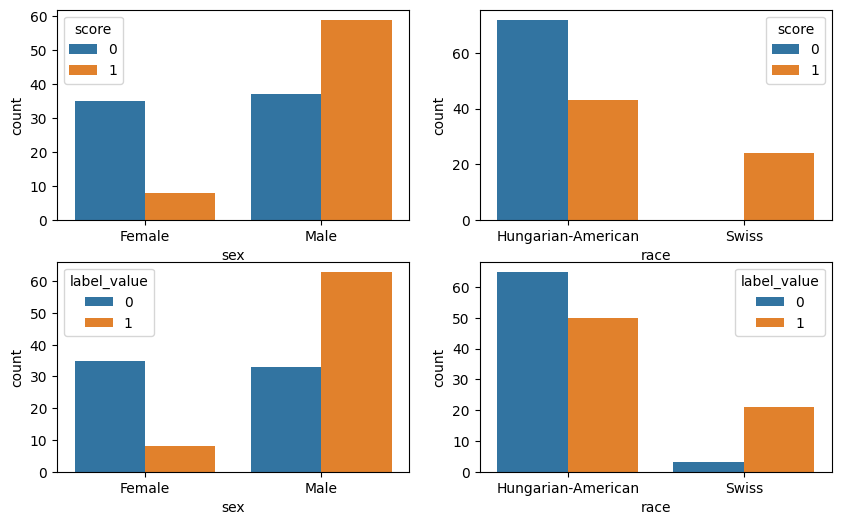

In [10]:
fig, ax = subplots(2, 2, figsize = (10, 6))

sns.countplot(x = "sex",  hue = "score", data = df_aeq1, ax = ax[0][0]);
sns.countplot(x = "race", hue = "score", data = df_aeq1, ax = ax[0][1]);

sns.countplot(x = "sex",  hue = "label_value", data = df_aeq1, ax = ax[1][0]);
sns.countplot(x = "race", hue = "label_value", data = df_aeq1, ax = ax[1][1]);

# 4. Visualize bias in the model ( Support Vector Classifier )

The DataFrame below presents evaluation metrics of a binary classifier that has been trained to predict a certain outcome based on two attributes: `sex` and `race`.

Here are some potential biases that could be interpreted from the DataFrame:

   * `Gender (Sex) bias`: The `TPR` for females is 0.75 and for males is 0.78, while the `Precision` for females is 0.75 and for males is 0.83. This suggests that the classifier may be slightly less accurate at predicting the outcome for females, as both the `TPR` and `PPV` are lower for this group. Additionally, the `PPR` for males is much higher than for females, with a value of 0.88 compared to 0.12 for females.
   
   
   * `Racial (Race) bias`: The `TNR` for Hungarian-Americans is 0.86 and for Swiss individuals is 0.00, while the `NPV` for Hungarian-Americans is 0.78 and for Swiss individuals is NaN. This suggests that the classifier may be slightly less accurate at predicting the outcome for Swiss, as both the `TNR` and `NPV` are lower for this group. The `FPR` and `prevalence` for Swiss individuals are both 1.0, which indicates that the classifier is unable to make any true negative predictions for this group. It is unclear why the classifier is unable to make any true negative predictions for Swiss individuals, but this could be due to a small sample size or some other issue with the training data.

In [11]:
# must discretize continuous attribute columns prior to passing the data to Group().get_crosstabs()
df_aeq, _ = preprocess_input_df(df_aeq1)

g = Group()
xtab, _ = g.get_crosstabs(df_aeq)

In [12]:
absolute_metrics = g.list_absolute_metrics(xtab)

xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,sex,Female,0.75,0.94,0.06,0.25,0.06,0.25,0.94,0.75,0.12,0.19,0.19
1,sex,Male,0.78,0.70,0.38,0.17,0.30,0.22,0.62,0.83,0.88,0.61,0.66
2,race,Hungarian-American,0.68,0.86,0.22,0.21,0.14,0.32,0.78,0.79,0.64,0.37,0.43
3,race,Swiss,1.00,0.00,NaN,0.12,1.00,0.00,NaN,0.88,0.36,1.00,0.88


# 5. What levels of disparity exist between population groups?

The disparities are measured as ratios between the reference group and the target group. A ratio of 1 indicates no disparity, a ratio greater than 1 indicates that the reference group is advantaged compared to the target group, and a ratio less than 1 indicates that the reference group is disadvantaged compared to the target group. NaN values indicate missing data or undefined ratios.

In general, the disparities in the DataFrame below suggest that there may be biases or unfairness in the predictive model for certain attribute values, which could lead to unequal treatment or outcomes for different groups.

In [13]:
b = Bias()

# automate base group selection based on dataset characterisitcs
# the reference group is Male and Hungarian-American and can be manually written
# but it is decided that Aequitas handles it.
majority_bdf = b.get_disparity_major_group(xtab, original_df = df_aeq)

majority_bdf[['attribute_name', 'attribute_value'] +  b.list_disparities(majority_bdf)]

get_disparity_major_group()


,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,sex,Female,0.135593,0.302720,0.903061,1.475000,0.15102,0.188571,1.125,0.964286,1.352795,1.51677
1,sex,Male,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000,1.000000,1.000000,1.00000
2,race,Hungarian-American,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000,1.000000,1.000000,1.00000
3,race,Swiss,0.558140,2.674419,1.106618,0.597222,NaN,7.222222,0.000,1.470588,0.000000,NaN


# 6. How to assess the model fairness?

The DataFrame below lists various fairness metrics for different attributes, namely `race` and `sex`. Each fairness metric indicates whether there is fairness violation for the corresponding attribute.

For race, `FOR parity`, `NPV parity`, `Precision parity` are satisfied. However, the others are not satisfied, which suggests that the classifier may have biased outcomes with respect to race.


For sex, `Precision parity`, `TPR parity`, , and `FNR parity` are satisfied, while the others are not satisfied. `Precision parity` and `NPV parity` are not satisfied, which indicates that there may be disparities in predictive accuracy for different groups.

At the end, the results shows that the Overall Fairness is False, which means that the there is fairness violation in the results.

In [14]:
f = Fairness()
fdf = f.get_group_value_fairness(majority_bdf)

In [15]:
gaf = f.get_group_attribute_fairness(fdf)
gaf[['attribute_name'] + f.list_parities(fdf)]

,attribute_name,Impact Parity,FPR Parity,TPR Parity,FNR Parity,Supervised Fairness,Equalized Odds,FOR Parity,TypeII Parity,Statistical Parity,NPV Parity,TypeI Parity,FDR Parity,Precision Parity,TNR Parity,Unsupervised Fairness
0,race,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False
1,sex,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False


In [16]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

# 7. What can be done after finding fairness violations?

After finding fairness violations in an algorithm, several actions can be taken to address the issue, including:

* `Adjusting the algorithm`: The algorithm can be modified to address the bias and improve fairness. This can involve adjusting the data used to train the model or the algorithm itself to remove the sources of bias.

* `Collecting more data`: Collecting more data from underrepresented groups can help to balance the dataset and reduce bias in the algorithm.

* `Removing or downweighting sensitive attributes`: Removing or downweighting sensitive attributes, such as race or gender, from the data can reduce the likelihood of bias in the algorithm.

* `Implementing fairness constraints`: Fairness constraints can be incorporated into the algorithm to ensure that it meets specific fairness criteria.

* `Monitoring and evaluating the algorithm`: It is important to continually monitor and evaluate the algorithm to ensure that it remains fair and unbiased over time. This can involve regularly checking for fairness violations and making adjustments as needed.